In [20]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

stats = pd.read_json('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json')

stats['data'] = stats['data'].transform(lambda s: s[:10])
stats.sort_values(by=['data'], inplace=True)
stats['data'] = pd.to_datetime(stats['data'])
stats['data'] = stats['data'].dt.strftime('%d %b')

measures = ['deceduti', 'terapia_intensiva', 'dimessi_guariti','totale_casi']
sub_measures = {
#     'delta_perc': { 'color': 'steelblue', 'label': 'Variazione percentuale', 'is_percentage': True },
    'delta': { 'color': 'plum', 'label': 'Derivata prima', 'is_percentage': False },
    'delta_2': { 'color': 'sandybrown', 'label': 'Derivata seconda', 'is_percentage': False },
    'delta_3': { 'color': 'steelblue', 'label': 'Derivata terza', 'is_percentage': False }
}

for measure in measures:
    stats[f'{measure}_delta_perc'] = stats[measure].pct_change()*100
    stats[f'{measure}_delta'] = stats[measure].diff()
    stats[f'{measure}_delta_2'] = stats[f'{measure}_delta'].diff()
    stats[f'{measure}_delta_3'] = stats[f'{measure}_delta_2'].diff()

stats.dropna(inplace=True)

stats.loc[3,'dimessi_guariti_delta_perc'] = stats.loc[2:4:2,'dimessi_guariti_delta_perc'].sum()/2

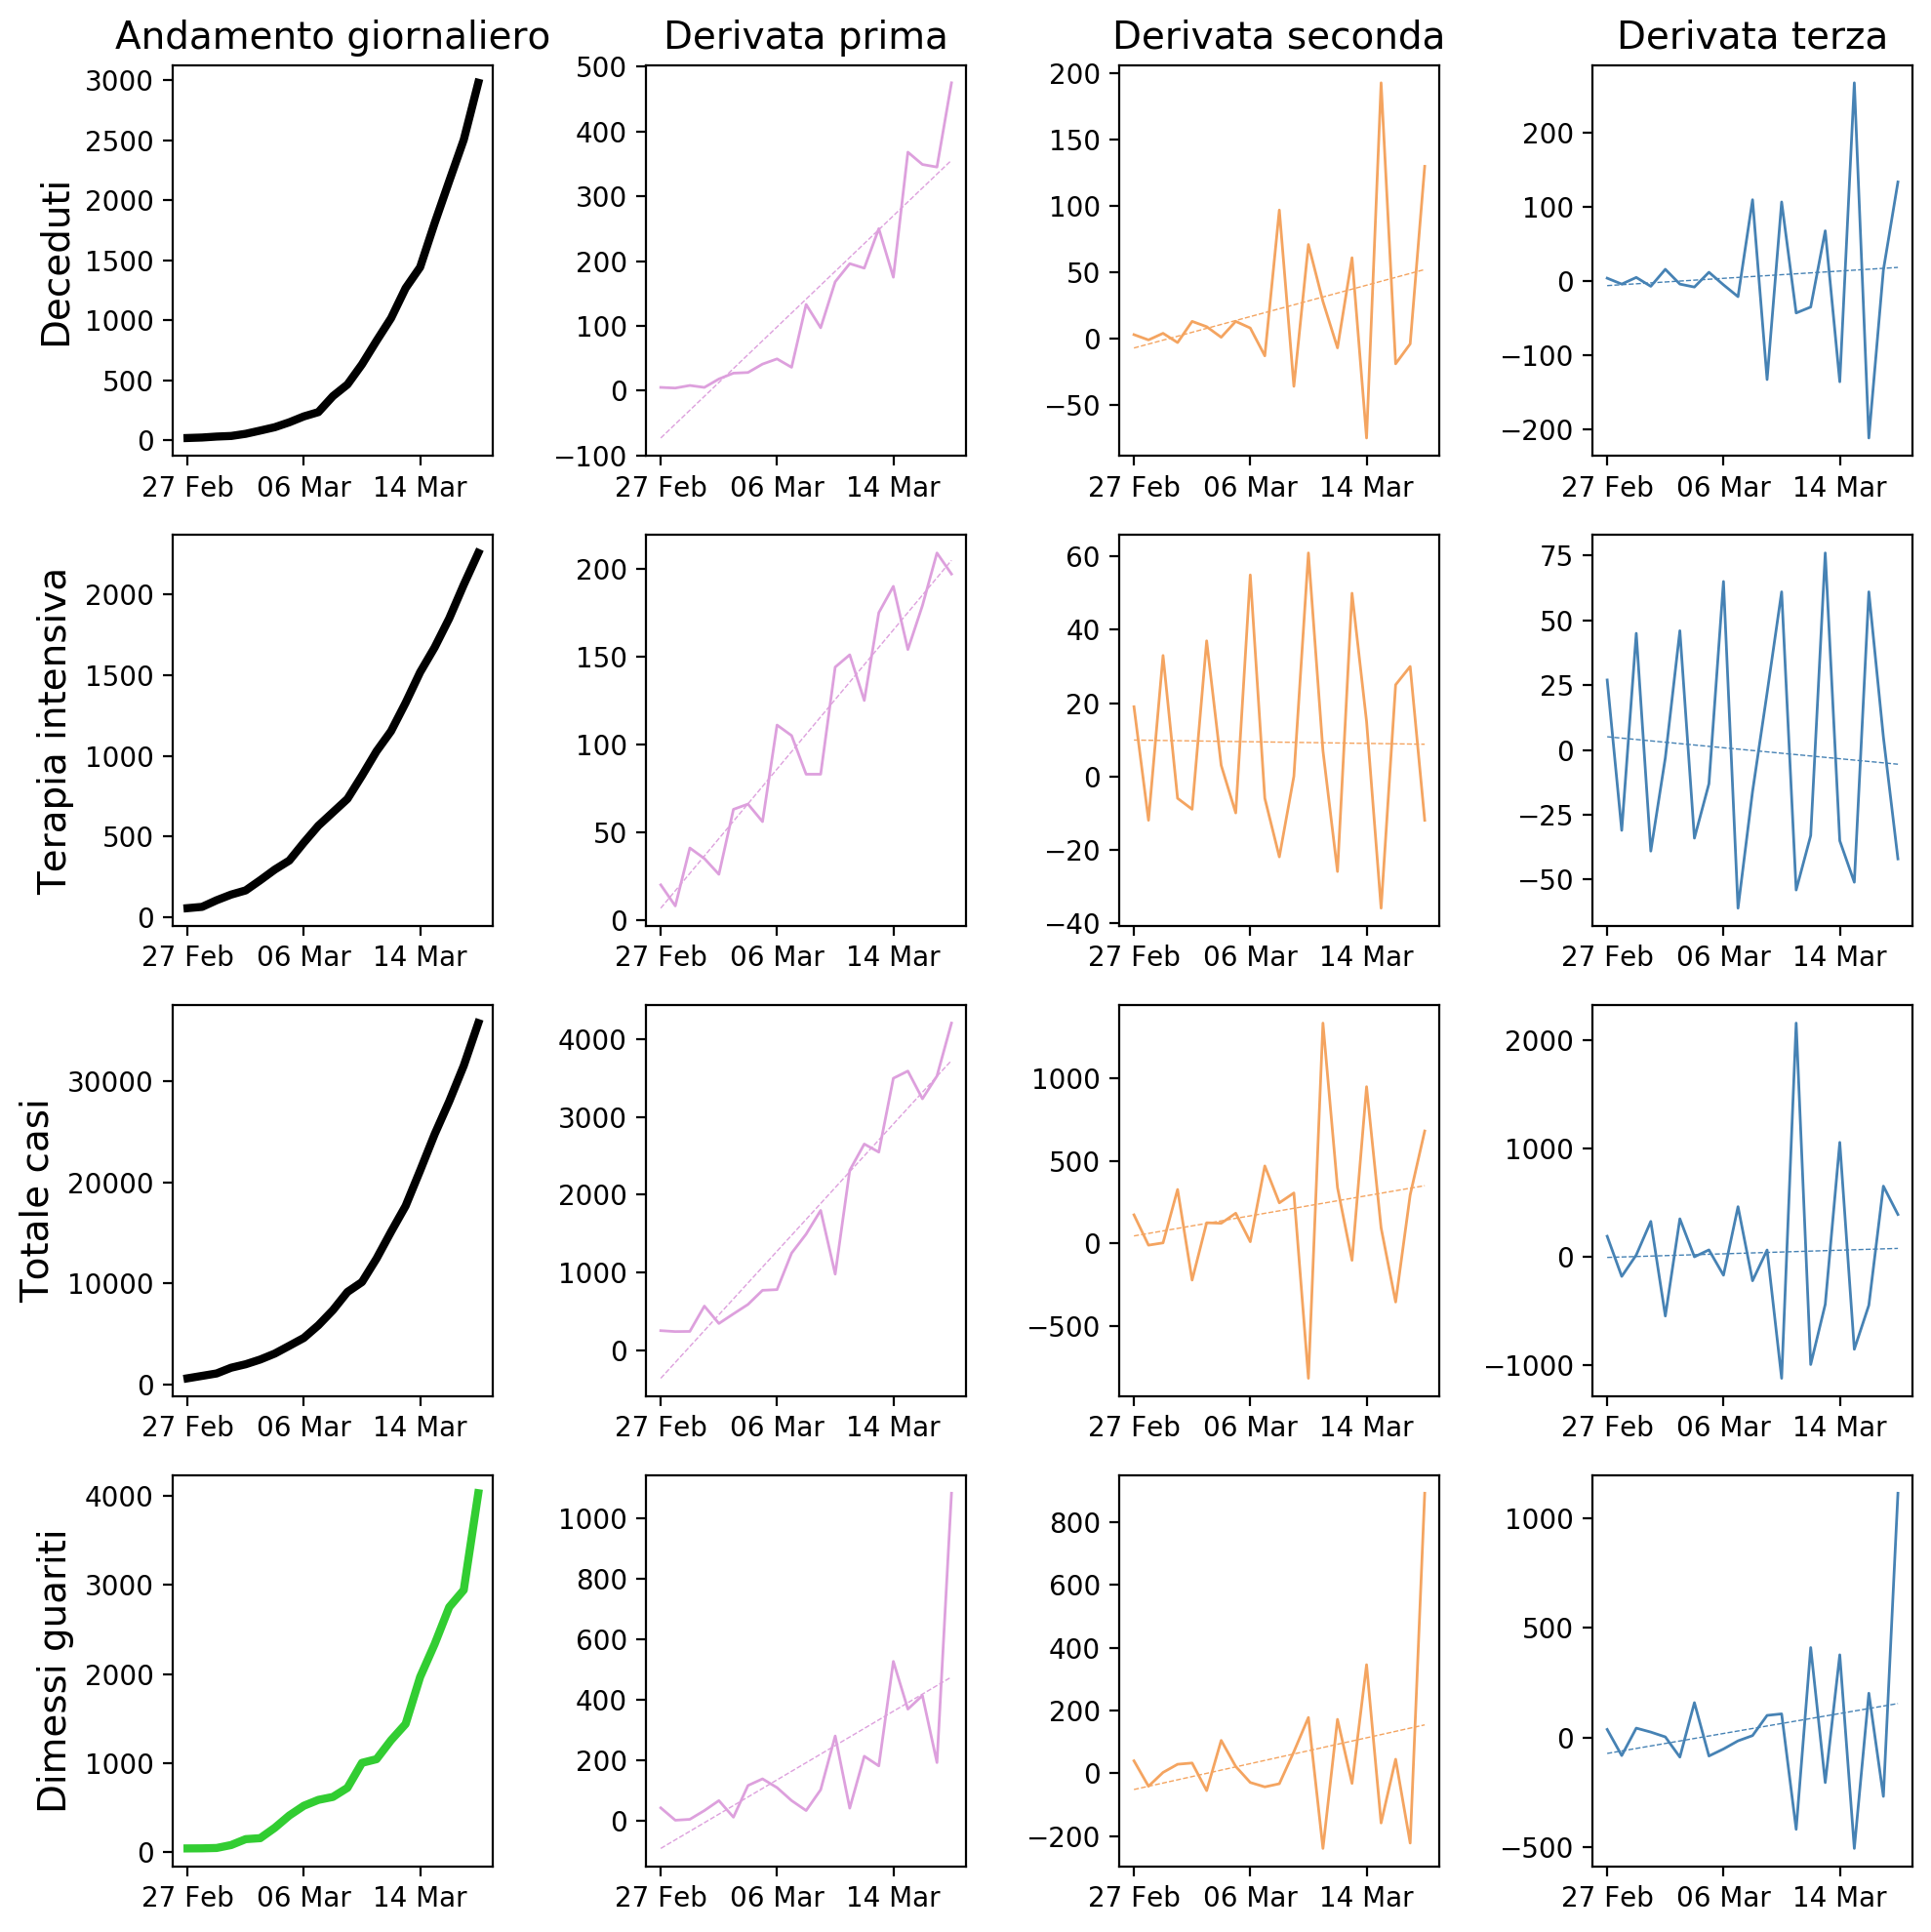

In [21]:
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
from scipy.ndimage.filters import gaussian_filter1d

def plot(ax, measure, is_first_row=False, main_color='black'):
    x = stats['data']
    y = stats[measure]

    ax[0].plot(x, y, color=main_color, lw=3)
    ax[0].set_ylabel(measure.replace('_', ' ').capitalize(), fontsize=14)
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(3))
    
    if is_first_row:
        ax[0].set_title('Andamento giornaliero', fontsize=14)

    for i, sub_measure in enumerate(sub_measures):
        color = sub_measures[sub_measure]['color']
        label = sub_measures[sub_measure]['label']
        if is_first_row:
            ax[i+1].set_title(label, fontsize=14)

        y_sub = stats[f'{measure}_{sub_measure}']
#         ax[i+1].plot(x, gaussian_filter1d(y_sub, sigma=1), color=color, lw=0.5)
        ax[i+1].plot(x, y_sub, color=color, lw=1)

        # trendline
        z = np.polyfit(range(len(x)), y_sub, 1)
        p = np.poly1d(z)
        ax[i+1].plot(range(len(x)), p(range(len(x))), color=color, lw=0.5, ls='--')

        # limit number of x ticks
        ax[i+1].xaxis.set_major_locator(plt.MaxNLocator(3))
        
        if sub_measures[sub_measure]['is_percentage']:
            ax[i+1].yaxis.set_major_formatter(mtick.PercentFormatter())

        
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10), dpi=200)
plot(axes[0], 'deceduti', True)
plot(axes[1], 'terapia_intensiva')
plot(axes[2], 'totale_casi')
plot(axes[3], 'dimessi_guariti', False, 'limegreen')

plt.tight_layout()